We assume the images are located in the the `images` folder, itself located at the root folder of the project.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2

from numpy import pi
from numpy.fft import ifft2
from scipy.signal import convolve2d

from utils import read_pgm, read_eye_annotations

In [2]:
image = read_pgm(0)
left_eye, right_eye = read_eye_annotations(img_no=0)

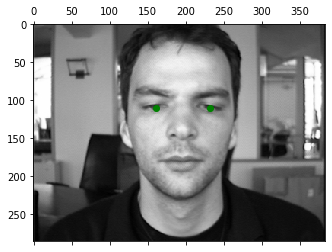

In [3]:
f, ax = plt.subplots()
ax.matshow(image, cmap='gray')
_ = ax.scatter([left_eye[0]], [left_eye[1]], c='green')
_ = ax.scatter([right_eye[0]], [right_eye[1]], c='green')

In [4]:
image.shape

(286, 384)

In [5]:
from spline import make_first_order_spline, make_k_th_order_spline
from spline import make_spline_first_derivative,make_2d_spline_patch

## Linear regression of patches (no regularization)

In [6]:
def plot_cross(N):
    XX, YY = np.meshgrid(np.arange(N), np.arange(N))
    # XY = np.stack([XX, YY], axis=-1)
    
    upper_left_diag = np.abs(XX - YY) < (N/20)
    upper_right_diag = np.logical_and(np.abs(XX + YY) > 0.95 * N, np.abs(XX + YY) < 1.05 * N)
    return np.logical_or(upper_left_diag, upper_right_diag)

In [7]:
def circle_and_cross(N):
    circle =  plot_circle(N)
    cross = plot_cross(N)
    return np.logical_or(circle, cross)

In [8]:
Nx = Ny = 251  # Size of training samples
Nk = 51  # Size of the patches (x-direction)
Nl = 51  # Size of the patches (y-direction)
spline_deg = 3  # Degree of the B-spline used

In [9]:
def _make_gaussian_patch(N, sigma):
        XX, YY = np.meshgrid(np.arange(N), np.arange(N))
        XY = np.stack([XX, YY], axis=-1)
        
        center = np.array([(N-1) / 2, (N-1) / 2])
        XY_centered  = XY - center[np.newaxis, np.newaxis, :]
        
        gaussian_window = np.exp(np.linalg.norm(XY_centered/sigma, axis=2) ** 2)
        return gaussian_window

In [10]:
from math import factorial
def make_m_function_cake(N):
    def M_n(rho, t=0.5):
        rho = rho ** 2 / t
        ret =  np.exp(-rho) * sum((rho ** k) / factorial(k) for k in range(N + 1))
        return ret
    return M_n

In [11]:
x = _make_gaussian_patch(100, 20)

In [12]:
def make_polar_coordinates(N, bandwidth=5):
    XX, YY = np.meshgrid(bandwidth/N * (np.arange(N) - (N - 1)/2),
                         bandwidth/N * (np.arange(N) - (N - 1)/2))
    XY = XX + 1j * YY
    return np.abs(XY), np.mod(np.angle(XY) + pi, 2*pi)

In [13]:
def make_psi_cake_fourier_domain(spline_order, mn_order, num_slices, orient):
    def psi_fourier_domain(rho, phi):
        s_theta = 2 * np.pi / num_slices

        B_k = make_k_th_order_spline(0, spline_order)  # ??
        M_n = make_m_function_cake(mn_order)  # MnOrder: 8

        # the + (spline_order/2) is due to recenter my spline orientation
        return B_k(
            (np.mod(phi - orient, 2 * pi) - pi / 2) / s_theta + (spline_order) / 2
        ) * M_n(rho)

    return psi_fourier_domain

In [14]:
def make_psi_cake_spatial_domain(k, N, N0, orient):
    def psi_spatial_domain():
        rhos, phis = make_polar_coordinates(N)

        psi_fourier = make_psi_cake_fourier_domain(
            spline_order=k, mn_order=8, num_slices=20, orient=orient
        )
        gaussian_window = _make_gaussian_patch(N=N, sigma=N / 4)

        psi_vals = psi_fourier(rhos, phis)
        
        w = ifft2(np.fft.ifftshift(psi_vals)).imag * gaussian_window
        
        # re-arrange the patch
        for l in range(w.shape[0]):
           w[l] = np.roll(w[l, :], w.shape[0] // 2)

        for c in range(w.shape[1]):
           w[:, c] = np.roll(w[:, c], w.shape[1] // 2)
        
        return w, psi_vals, phis

    return psi_spatial_domain

In [15]:
def plot_circle(N):
    XX, YY = np.meshgrid(np.arange(N), np.arange(N))
    XY = np.stack([XX, YY], axis=-1)
    center = np.array([(N - 1) / 2, (N - 1) / 2])
    radius = N/3
    
    val = np.linalg.norm(XY - center[np.newaxis, np.newaxis, :], axis=2)
    ret_one = 1 * np.logical_and(val < 1.1*radius, val > 0.9 * radius)
    ret_two = 0 * np.logical_or(val > 1.1*radius, val < 0.9 * radius)
    return (ret_one + ret_two)

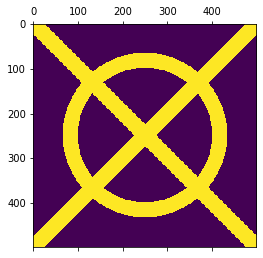

In [18]:
img = circle_and_cross(500)
plt.matshow(img)

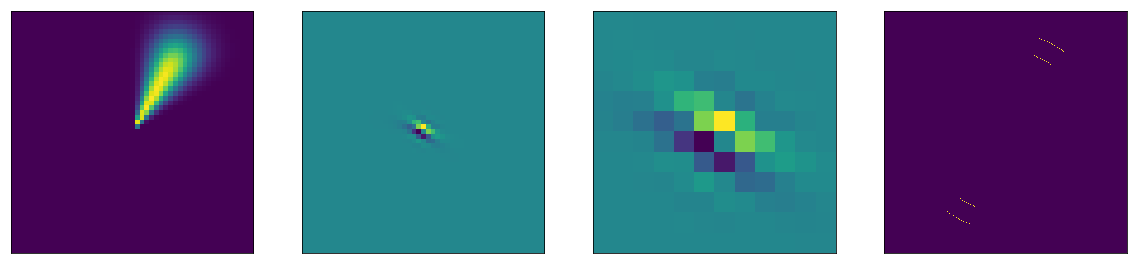

In [19]:
# img = plot_circle(500)

w, psi_vals, phis = make_psi_cake_spatial_domain(4,51, 6, pi/6)()


N = w.shape[0]
f, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(20, 5))
ax1.matshow(psi_vals)
ax2.matshow(w)
ax3.matshow(w[int(3*N/8):int(5*N/8), int(3*N/8):int(5*N/8)])
convolved_image = convolve2d(img, w, mode='valid') 
ax4.matshow(np.abs(convolved_image) > 200)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)

ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)

ax4.get_xaxis().set_visible(False)
ax4.get_yaxis().set_visible(False)

In [17]:
c_imgs = []
for angle in np.linspace(0, pi, 30):
    print(angle)
    w, psi_vals, phis = make_psi_cake_spatial_domain(4,51,6,angle)()
    convolved_img = convolve2d(img, w, mode='valid')
    c_imgs.append(convolved_img)

0.0
0.10833078115826873
0.21666156231653746
0.3249923434748062
0.43332312463307493
0.5416539057913436
0.6499846869496124
0.7583154681078811
0.8666462492661499
0.9749770304244186
1.0833078115826873
1.191638592740956
1.2999693738992248
1.4083001550574936
1.5166309362157622
1.624961717374031
1.7332924985322997
1.8416232796905685
1.9499540608488373
2.058284842007106
2.1666156231653746
2.2749464043236434
2.383277185481912
2.491607966640181
2.5999387477984497
2.7082695289567185
2.8166003101149872
2.9249310912732556
3.0332618724315243
3.141592653589793


In [260]:
all_non_zero = []
threshold = 200
all_x = []
all_y = []
all_z = []
i = 0
for c_img, angle in zip(c_imgs, np.linspace(0, pi, 30)):
    x, y = np.where(1*(np.abs(c_img) >= np.max(np.abs(c_img)-2)))
    z = np.repeat(angle, len(x))
    
    all_x.append(x)
    all_y.append(y)
    all_z.append(z)
    assert len(x) == len(y)
    
all_x = np.concatenate(all_x)
all_y = np.concatenate(all_y)
all_z = np.concatenate(all_z)

In [20]:
import ipyvolume

In [21]:

ipyvolume.quickvolshow(1*np.stack(c_imgs, axis=-1)>180, level=[1], level_width=1)

/home/pierreglaser/.virtualenvs/geodesic_methods/lib/python3.7/site-packages/ipyvolume/widgets.py:179: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_view = self.data_original[view]
/home/pierreglaser/.virtualenvs/geodesic_methods/lib/python3.7/site-packages/ipyvolume/utils.py:204: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data = (data[slices1] + data[slices2])/2
/home/pierreglaser/.virtualenvs/geodesic_methods/lib/python3.7/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradien

In [740]:

c_imgs = np.stack(c_imgs, axis=-1)
c_imgs.shape

(250, 250, 30)

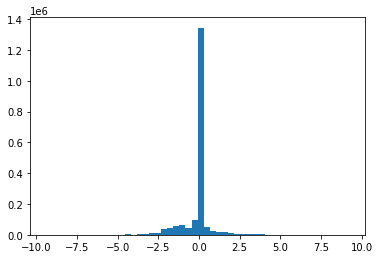

In [749]:
_ = plt.hist(c_imgs.flatten()/np.std(c_imgs.flatten()), bins=50)

In [ ]:
import plotly.graph_objects as go

X, Y, Z = np.mgrid[0:c_imgs.shape[0],
                   0:c_imgs.shape[1],
                   0:pi:1j*c_imgs.shape[2]]
values = c_imgs

fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=values.flatten(),
    isomin=-10,
    isomax=70,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=17, # needs to be a large number for good volume rendering
    ))
fig.show()

In [719]:
c_imgs = np.stack(c_imgs)

In [706]:

from scipy.signal import convolve2d
img = circle_and_cross(200)

In [279]:
# convolved_circle_and_cross = np.fft.ftt2(img) * np.fftnp.conjugate(p))